# Data Science and Big Data Analytics - Group Projects

For the project, we give you access to a database we actively use for our research on open source software development. The database contains information collected from the version control system, the issue tracker, and the mailing lists of the projects. [You can find a documentation of the available data online](https://smartshark2.informatik.uni-goettingen.de/documentation/). 

## Your task

The database contains data for many Apache Projects. For your group projects, only the following 39 projects are relevant:
- ant-ivy, archiva, calcite, cayenne, commons-bcel, commons-beanutils, commons-codec, commons-collections, commons-compress, commons-configuration, commons-dbcp, commons-digester, commons-io, commons-jcs, commons-jexl, commons-lang, commons-math, commons-net, commons-rdf, commons-scxml, commons-validator, commons-vfs, deltaspike, eagle, giraph, gora, jspwiki, kylin, lens, mahout, manifoldcf, nutch, opennlp, parquet-mr, santuario-java, systemml, tika, wss4j

Your task is to develop an automated model for clustering project popularity over time. The model should be designed so that it can be used on GitHub, for example, to showcase trending or popular projects for a specific period of time. How many labels are useful for clustering depends on your decision. 

You have to frame these questions into an analytic problem. Then, you have to create models that can be used to answer the questions. You have to choose appropriate features from the available data for this and decide which kind of analytic approach to use. Finally, you have to evaluate how well your approach performs. 

## Group registrations

You have to work in groups of three people on this task. **One member of each group must register the whole group via an email to Benjamin Ledel (benjamin.ledel@cs.uni-goettingen.de) until Friday, May 21th**. If you are fewer than three people, you register the same way and we will assign you additional group members from other groups with less than three people on May 24th. **This registration, as well as the successful participation of your group is a mandatory requirement for the participation in the exam!**


## Presentation and voting

**All results must be presented in the final lecture on Jul 13th, which will already start at 10:00 o'clock.** Each group must give four minute presentation. Within this presentation, you should briefly describe which data you analyzed, how you treated it, which models you used, and your key findings. The time available for the presentation depends on the number of groups and may be increased. This will be announced in July.

Afterwards, everybody in attendance will vote to determine the best project. Each group votes for the best project (3 points), second best (2 points), and third best (1 point). The one with the most points wins a price. 

## Submission of the presentation

In order to allow the presentation session to run smoothly, each group must submit their presentation beforehand. 
**Send the presentation latest on Jul 9th, 10:00 o'clock to Benjamin Ledel via Email (benjamin.ledel@cs.uni-goettingen.de)**. The presentations must be PDF format. Other formats are not allowed. 

## Success criteria

The following criteria must be fulfilled by a project, such that the group members can participate in the exam:
- A model for automated clustering of the project popularity.
- An evaluation of the quality of the clustering model.
- A recommendation on how the model could be used, including key benefits and risks.
- The model must be applied to at least 30 projects from the database, which must all be considered for the evaluation.
- A presentation of the results is given in the final lecture on Jul 13th.


## Getting started

The cell below shows how to access the data with Python. Please note that the database is behind a firewall and can only be accessed from within the Goenet. If you cannot reach the database, just establish a connection to the [VPN of the GWDG](https://info.gwdg.de/docs/doku.php?id=en:services:network_services:vpn:anyconnect) and it should be reachable. 

**WARNING:
Because we also actively use the MongoDB in our research, there can sometimes be heavy load on the database. The database currently contains 3.3 Terabytes of data. Do not just randomly query the database, but fetch only the data you need. Otherwise you might easily try to download several Gigabytes of data. For example, if you want to fetch all information that is stored in the ```commit``` collection, you will download 127 Gigabytes of data.**

### Accessing the database with Python

You can use the [pycoSHARK](https://github.com/smartshark/pycoshark) library for accessing the MongoDB. The pycoSHARK provides an ORM layer based on the mongoengine library. Alternatively, you can also access the database with native MongoDB queries using the [pymongo](https://api.mongodb.com/python/current/) API. 

The code below shows how to use the database with the pycoSHARK. 

In [1]:
# code for installing our own library for accessing the MongoDB through a ORM engine
import sys
!{sys.executable} -m pip install pycoshark

In [2]:
from mongoengine import connect
from pycoshark.mongomodels import People, Commit, Project, VCSSystem,CloneInstance,PullRequest,
Issue, IssueSystem,PullRequestSystem,Message,MailingList 
from pycoshark.utils import create_mongodb_uri_string

# Database credentials
user = 'datascience2021'
password = '43QAt5bd91'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

# Fetch project id and version control system id for the 'kafka' project
# The only() decides the data that is actually retrieved from the MongoDB. Always restrict this to the field that you require!
project = Project.objects(name='commons-math').only('id').get()
vcs_system = VCSSystem.objects(project_id=project.id).only('id','url').get()
print('url of VCS system of the project: %s' % vcs_system.url)

# determine latest commit of the commons-math project
last_commit = None
max_date = None
# loop over all commits of kafka
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('committer_date', 'committer_id','revision_hash').timeout(False):
    if max_date is None:
        last_commit = commit
        max_date = commit.committer_date
    if max_date<commit.committer_date:
        last_commit = commit
        max_date = commit.committer_date
        
print('revision hash of last commit in database: %s' % last_commit.revision_hash)
print('date of last commit in database: %s' % last_commit.committer_date)
print('link to commit on Github: https://github.com/apache/commons-math/commit/%s' % last_commit.revision_hash)

# fetch committer from People
last_committer = People.objects(id=last_commit.committer_id).only('name','email').get()
print('last commit by %s (%s)' % (last_committer.name,last_committer.email))

url of VCS system of the project: https://github.com/apache/commons-math
revision hash of last commit in database: c965f1c7fca41baf313e2234c6328f4082fe9ab2
date of last commit in database: 2018-02-15 10:05:50
link to commit on Github: https://github.com/apache/commons-math/commit/c965f1c7fca41baf313e2234c6328f4082fe9ab2
last commit by Gilles (erans@apache.org)


In [3]:
import numpy as np
import pandas as pd

In [4]:
author_id_list = []
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('id','committer_date', 'committer_id','author_id').timeout(False):
    author_id_list.append(commit.id)
    


In [5]:
vcs_system.id

ObjectId('58bfd79dfa94f2c7f0d32551')

In [6]:
#author_id_list

In [7]:
len(author_id_list)

7222

In [8]:
commit_date_list = []
for commit in Commit.objects(vcs_system_id=vcs_system.id).only('committer_date', 'committer_id','author_id').timeout(False):
    print(commit.committer_date)
    commit_date_list.append(commit.committer_date)
    


2014-12-03 11:25:09
2015-02-23 21:44:38
2014-01-24 09:58:43
2013-10-31 20:07:38
2013-02-26 09:29:25
2013-07-16 13:35:19
2013-03-08 16:57:28
2012-12-16 15:01:12
2012-11-10 16:51:49
2012-09-12 03:18:46
2011-12-09 11:14:06
2012-01-13 07:04:10
2011-07-10 13:48:36
2011-11-26 12:01:58
2011-03-21 08:52:14
2011-12-01 14:36:50
2011-06-20 19:48:44
2011-01-20 21:31:54
2011-01-12 11:07:42
2010-03-06 18:54:27
2006-11-23 04:17:13
2005-09-04 00:38:15
2003-07-09 16:24:18
2016-05-30 17:25:18
2004-10-28 03:02:34
2015-11-09 22:11:33
2015-12-31 22:56:59
2003-06-24 14:03:32
2015-11-04 13:51:03
2003-06-27 20:31:52
2003-09-07 03:12:56
2015-11-23 22:16:58
2004-06-18 13:24:46
2011-01-22 20:22:51
2011-02-14 14:18:21
2015-10-31 15:15:35
2011-02-20 11:27:16
2016-04-23 12:33:41
2015-10-27 19:33:39
2015-01-21 20:03:41
2015-08-31 11:47:05
2015-04-10 19:06:37
2015-09-19 12:57:49
2015-01-26 21:11:05
2015-09-06 17:49:51
2014-12-16 12:37:58
2015-08-13 21:27:40
2015-04-30 16:35:05
2014-12-15 20:21:09
2015-04-10 00:47:34


2011-01-21 21:45:29
2015-12-25 14:29:04
2016-05-17 13:30:23
2004-07-19 00:01:05
2016-10-12 10:41:45
2016-01-06 13:20:00
2015-12-08 19:26:54
2016-04-21 22:16:35
2015-04-14 11:40:34
2015-08-31 11:50:52
2015-09-17 22:09:23
2015-12-28 17:12:35
2015-06-21 17:44:01
2009-07-19 18:23:21
2015-08-24 20:18:01
2011-02-21 15:27:39
2003-06-11 14:50:30
2011-01-24 19:09:26
2004-02-18 04:04:18
2003-11-15 18:52:31
2011-01-08 17:50:54
2016-05-30 21:15:29
2016-01-01 22:07:30
2015-12-27 23:43:04
2015-12-24 22:23:05
2015-12-04 10:31:26
2008-02-11 05:15:30
2015-05-05 14:00:17
2015-09-10 08:34:08
2015-08-20 22:26:59
2015-05-01 13:44:08
2015-02-25 21:25:47
2014-12-19 14:15:52
2015-03-02 21:41:44
2014-12-17 18:01:27
2014-12-01 13:48:48
2014-06-28 20:12:58
2011-08-15 21:16:57
2014-11-12 11:16:13
2014-03-27 21:47:41
2014-01-29 20:19:20
2013-06-10 22:22:31
2014-01-03 18:05:04
2013-11-07 17:16:04
2013-09-03 19:51:26
2013-07-02 20:00:47
2013-11-16 18:48:48
2013-04-07 12:47:32
2013-11-02 20:46:04
2013-03-25 10:19:51


2015-01-07 21:07:52
2014-12-16 16:23:48
2014-10-07 11:54:55
2014-07-04 14:22:30
2014-05-04 23:19:43
2014-02-18 14:33:57
2014-05-19 15:00:03
2014-05-01 12:14:14
2013-11-10 19:59:15
2013-11-28 11:41:12
2013-08-23 15:37:29
2013-09-11 22:53:56
2013-08-26 03:18:55
2010-06-16 13:53:18
2013-05-26 15:59:03
2013-07-18 14:59:48
2013-03-15 13:54:20
2011-10-16 21:04:19
2009-12-09 02:37:00
2013-03-09 14:34:05
2012-11-28 05:39:39
2012-12-18 22:08:38
2012-11-24 04:24:26
2012-07-20 00:43:45
2012-06-08 20:10:49
2012-03-01 22:30:26
2012-09-12 03:46:31
2012-08-16 21:00:39
2012-09-27 18:42:45
2012-09-27 03:49:54
2012-08-31 03:12:16
2012-09-10 17:42:53
2012-11-09 08:13:18
2012-02-16 21:14:15
2012-07-16 13:38:12
2011-01-06 14:11:32
2010-11-12 13:57:53
2012-09-06 19:42:35
2012-05-24 19:23:37
2011-09-06 21:06:58
2011-07-24 11:21:55
2012-03-28 11:55:05
2008-11-23 14:57:44
2011-10-16 22:00:45
2012-01-12 08:08:29
2011-10-13 22:21:04
2011-07-22 22:51:37
2012-02-15 19:44:08
2012-01-18 07:50:21
2008-02-01 12:51:46


2004-01-29 16:52:41
2009-04-20 20:19:49
2003-05-22 16:55:22
2010-09-30 12:55:02
2005-12-12 02:43:38
2009-10-07 18:56:42
2009-09-01 20:05:22
2010-09-05 21:37:50
2009-07-20 21:27:12
2009-02-13 14:38:48
2008-11-03 21:36:31
2010-10-03 18:21:28
2010-02-16 11:20:17
2009-04-20 20:18:52
2008-04-24 09:03:43
2009-07-30 21:24:29
2009-07-25 17:57:05
2009-03-29 17:10:09
2009-01-18 16:13:12
2008-02-03 18:58:54
2009-07-01 20:57:20
2007-05-20 20:08:06
2008-04-24 13:20:53
2008-02-08 16:07:33
2007-12-02 19:21:02
2008-02-10 20:17:24
2009-05-20 17:48:27
2007-07-29 03:42:34
2007-11-03 12:53:19
2009-05-31 22:08:32
2007-02-26 22:59:45
2005-07-04 23:30:05
2009-04-23 04:09:27
2007-09-10 20:42:13
2008-01-10 13:53:42
2007-05-31 05:45:11
2004-01-29 04:32:27
2006-07-16 07:45:31
2004-07-11 18:59:52
2005-09-04 04:37:37
2005-07-03 06:44:54
2008-10-05 15:37:02
2003-07-07 02:12:47
2004-05-24 05:33:42
2005-07-30 07:25:26
2004-07-11 23:39:08
2004-04-20 21:01:35
2005-05-21 16:29:19
2008-02-16 16:31:03
2004-11-07 20:19:22


2009-01-19 23:40:14
2009-07-20 20:13:24
2010-05-30 18:30:50
2009-05-09 15:29:55
2009-06-09 15:34:55
2015-12-29 19:21:42
2008-09-26 19:51:13
2009-05-24 00:02:54
2009-04-11 15:33:38
2008-07-08 13:37:09
2008-06-14 20:59:31
2016-04-23 16:22:02
2008-05-18 15:20:00
2008-03-23 12:22:59
2011-01-21 15:22:43
2009-09-05 17:36:48
2011-01-06 15:30:39
2009-01-19 19:43:01
2010-12-28 09:03:40
2008-02-04 00:58:24
2015-12-28 15:33:03
2007-11-05 17:11:29
2009-05-04 02:59:30
2007-09-10 14:36:21
2009-04-30 12:05:22
2009-02-21 20:21:38
2007-02-01 07:03:52
2006-11-09 00:26:31
2007-07-29 16:22:53
2009-01-05 01:01:16
2007-05-27 18:35:14
2007-03-13 20:04:22
2004-11-08 00:56:06
2007-07-22 02:33:08
2004-06-23 16:26:18
2005-06-26 21:31:28
2007-07-31 21:59:07
2005-06-05 04:16:01
2008-07-15 11:53:23
2007-03-25 17:26:35
2008-03-31 15:39:17
2008-06-10 19:32:52
2004-11-07 05:07:29
2004-08-22 01:42:58
2004-08-22 01:39:35
2003-06-25 01:39:36
2003-06-21 01:55:17
2004-07-11 18:38:12
2006-12-19 22:11:07
2004-06-18 07:03:40


2015-05-07 14:44:17
2011-02-22 19:52:17
2016-01-02 09:28:21
2010-11-14 21:32:57
2015-05-19 11:44:52
2016-01-01 14:11:57
2016-05-31 00:38:16
2005-11-28 05:38:46
2008-11-03 21:37:51
2009-05-30 18:36:18
2016-08-23 00:11:34
2008-07-10 14:22:13
2010-02-23 21:09:25
2016-04-21 21:56:39
2008-02-17 16:55:24
2008-11-27 15:50:42
2008-12-06 17:11:07
2008-01-13 20:21:20
2008-02-10 16:23:59
2007-08-17 16:26:45
2008-02-01 16:31:43
2008-04-24 12:27:14
2005-11-02 06:27:53
2008-02-09 18:22:36
2008-01-09 05:16:00
2007-05-31 04:53:37
2004-12-04 20:47:46
2009-01-31 04:51:17
2008-04-24 14:40:29
2004-10-09 21:15:56
2004-09-19 22:47:27
2008-12-25 18:06:19
2006-07-04 21:01:10
2008-10-12 13:50:35
2008-07-27 18:52:38
2016-09-04 10:39:00
2007-03-06 20:03:37
2004-02-18 03:24:20
2004-06-19 21:16:12
2005-01-30 23:02:28
2003-10-05 21:50:17
2004-09-26 02:08:47
2016-01-06 11:40:49
2004-10-08 06:15:51
2008-01-10 13:57:14
2003-05-29 23:26:24
2004-01-18 03:45:02
2004-01-11 19:34:31
2004-07-25 16:29:25
2005-11-24 17:26:34


2008-07-21 17:45:31
2010-01-22 18:27:41
2007-05-14 04:28:00
2008-02-02 18:07:50
2007-09-10 07:38:55
2006-05-16 05:48:03
2008-02-07 21:17:35
2007-09-09 21:38:13
2007-09-09 18:46:38
2006-03-02 14:53:53
2007-04-05 14:48:48
2008-12-14 14:56:50
2003-07-07 16:57:33
2008-06-16 10:40:12
2005-02-24 21:03:25
2016-01-17 10:40:27
2004-10-08 05:53:18
2005-08-29 23:48:21
2004-10-09 21:21:42
2016-12-13 09:58:45
2003-05-21 15:10:51
2016-05-29 20:19:13
2004-02-20 06:22:39
2004-05-06 05:18:00
2015-11-03 19:58:05
2004-02-29 19:40:39
2006-03-05 20:36:14
2003-06-22 03:57:57
2011-02-23 10:05:32
2006-01-03 15:30:25
2010-11-26 17:58:14
2011-01-31 19:14:14
2011-01-23 11:04:32
2011-02-15 01:31:12
2016-04-18 23:22:17
2015-12-04 10:32:00
2004-05-30 22:13:35
2005-11-28 05:39:20
2003-06-25 13:31:25
2015-07-27 15:14:00
2011-01-01 01:23:02
2010-11-20 21:58:35
2005-11-24 19:37:11
2007-02-26 22:22:53
2016-05-31 13:24:25
2015-12-27 12:42:17
2015-09-04 12:39:27
2011-01-21 04:35:21
2015-10-27 19:40:24
2014-12-19 13:50:03


2008-12-24 10:47:53
2010-12-06 01:44:33
2009-06-22 00:26:09
2016-03-09 15:47:09
2009-12-30 01:27:40
2008-05-18 20:21:23
2009-04-05 14:20:18
2008-01-12 22:01:00
2015-09-04 14:11:41
2015-07-10 13:33:10
2015-02-25 20:18:32
2015-03-16 20:29:21
2015-01-08 13:49:27
2014-01-01 17:30:58
2014-11-23 20:46:22
2014-10-03 21:17:15
2014-03-19 18:43:39
2013-05-28 15:23:05
2013-10-21 21:36:37
2012-02-02 19:51:57
2013-10-21 21:00:03
2010-03-25 15:08:40
2009-12-30 01:03:32
2013-03-10 23:41:21
2012-09-05 18:23:54
2012-10-31 10:45:09
2013-02-07 12:41:36
2012-11-12 13:37:20
2012-07-30 19:07:05
2012-06-06 03:56:02
2012-09-08 22:56:11
2012-02-16 14:42:13
2012-08-12 21:22:58
2009-04-18 11:37:56
2011-10-02 09:25:27
2012-04-30 11:07:42
2012-02-16 06:52:09
2012-04-12 18:18:25
2012-01-19 22:29:08
2012-05-28 03:22:28
2011-04-14 17:37:36
2011-10-01 19:09:00
2011-12-12 07:03:29
2012-01-05 03:46:47
2011-09-09 02:09:44
2011-10-01 14:16:50
2007-08-19 16:21:56
2011-07-11 12:32:14
2011-07-26 11:00:32
2011-01-24 22:33:11


In [21]:
len(commit_date_list)

7222

In [22]:
#clone_list = []
#for clone in CloneInstance.objects(commit_id=vcs_system.id).only('committer_date', 'committer_id','author_id').timeout(False):
    #print(commit.committer_date)
    #commit_date_list.append(commit.committer_date)
    

In [23]:
projects = ['ant-ivy', 'archiva', 'calcite', 'cayenne', 'commons-bcel', 'commons-beanutils', 'commons-codec', 'commons-collections', 'commons-compress', 'commons-configuration', 'commons-dbcp', 'commons-digester', 'commons-io', 'commons-jcs', 'commons-jexl', 'commons-lang', 'commons-math', 'commons-net', 'commons-rdf', 'commons-scxml', 'commons-validator', 'commons-vfs', 'deltaspike', 'eagle', 'giraph', 'gora', 'jspwiki', 'kylin', 'lens', 'mahout', 'manifoldcf', 'nutch', 'opennlp', 'parquet-mr', 'santuario-java', 'systemml', 'tika', 'wss4j']

In [24]:
project_id_list = []
for project in projects:
    project_table = Project.objects(name=project).only('id').get()
    project_id_list.append(str(project_table.id))
    #vcs_system_table = VCSSystem.objects(project_id=project_table.id).only('id').get()
    #vcs_system_id_list.append(str(vcs_system_table.id))


In [25]:
print(project_id_list)

['58c8979e0da3ef6363ccb8de', '5b5838020da3ef04920e02fc', '5b34a9210da3ef789cc240ec', '5b3b2d520da3ef789ec953ea', '5c87a7300da3ef6c8a4bf6d8', '5bed276c0da3ef21a58b337a', '5bed58010da3ef21a58b337b', '5bed254e0da3ef21a62b756d', '5bed583a0da3ef21a58b337c', '5bed83440da3ef21a2107882', '5c87a9510da3ef6c89b69038', '5bee79dc0da3ef21a58b337d', '5bee7a580da3ef21a58b337f', '5bee7a9d0da3ef21a3a094b1', '5beebd530da3ef21a2107883', '5bbe0efb0da3ef0ddd6d593d', '58bfd5860da3ef7cef464c78', '5bec1d600da3ef21a3a094af', '5beebd870da3ef21a62b756e', '5beebdd90da3ef21a62b756f', '5bf29d060da3ef21a62b7570', '5bf29db50da3ef21a3a094b2', '5b62dc8b0da3ef049126bdb8', '5c5012230da3ef08914b280e', '5bf51bf90da3ef21a2107884', '5cae08e00da3ef745f799438', '5b6446e40da3ef048efc47dd', '5b43728b0da3ef07106a790f', '5b89102a0da3ef04920e02fe', '5b1f9fbb0da3ef49b7d0a480', '5c3f09db0da3ef512137483f', '5b45f6670da3ef0712a85125', '5b27c4cc0da3ef789daec0a1', '5b4769050da3ef0712a85126', '5caee5640da3ef745ec4cc84', '5b7ad7860da3ef0491

In [26]:
vcs_system_id_list = []
for id in range(len(projects)):
    vcs_system = VCSSystem.objects(project_id=project_id_list[id]).only('id').get()
    #print(str(vcs_system.id))
    vcs_system_id_list.append(str(vcs_system.id))


In [27]:
vcs = []
for id in range(len(vcs_system_id_list)):
    for commit in Commit.objects(vcs_system_id=vcs_system_id_list[id]).only('id', 'committer_date'):
        vcs.append([project_id_list[id],vcs_system_id_list[id],str(commit.id), str(commit.committer_date.year) ])     
#vcs

In [28]:
issue_system_id_list = []
for id in range(len(projects)):
    issue_system = IssueSystem.objects(project_id=project_id_list[id]).only('id').get()
    #print(str(vcs_system.id))
    issue_system_id_list.append(str(issue_system.id))


In [29]:
len(issue_system_id_list)

38

In [30]:
issues = []
for id in range(len(issue_system_id_list)):
    for issue in Issue.objects(issue_system_id=issue_system_id_list[id]).only('id', 'created_at'):
        issues.append([project_id_list[id],issue_system_id_list[id],str(issue.id), str(issue.created_at)]) 

#issues

In [31]:
from pycoshark.mongomodels import  PullRequestSystem
pull_request_system_id_list = []
count=0
for id in range(len(projects)):
    if id==35:
        pull_request_system = PullRequestSystem.objects(project_id=project_id_list[35]).only('id').filter()[0]
        pull_request_system_id_list.append(str(pull_request_system.id))
        pull_request_system = PullRequestSystem.objects(project_id=project_id_list[35]).only('id').filter()[1]
        pull_request_system_id_list.append(str(pull_request_system.id))
        continue
    pull_request_system = PullRequestSystem.objects(project_id=project_id_list[id]).only('id').get()
    #print(pull_request_system.id)
    pull_request_system_id_list.append(str(pull_request_system.id))

In [32]:
pull_request_system_id_list

['5ff1886a3fba52c925be8926',
 '5ff191bbd27122d9808566c1',
 '5ff18a77762382d902b65fed',
 '5ff18a9fb2afbb2208874c00',
 '5ff19d10ad38daddddf60f3e',
 '5ff1a65d989b36df774d2f29',
 '5ff1a68fd4248463249c995b',
 '5ff1a62f55a5f6bbfdd7863b',
 '60016d83530e2dd2493b3f7b',
 '5ff1a7f5598772821d80e3c5',
 '5ff1a835b8cea70784f681f8',
 '5ff1a86895ed09307edc25e6',
 '5ff1a8912d3d8b4c8de7cf9b',
 '5ff1a8b55478b13d464f4c01',
 '5ff1a8df0b2d2472f70f7e79',
 '5ff19c7217b18278cd7a89e6',
 '5ff188dbbbd12b5cb69992ba',
 '5ff1a9d8d64fd989a5786d51',
 '5ff1a909e016610c0dd52398',
 '5ff1a93b50cd55cd7c6c88f8',
 '5ff1a95f5cef2ffea959fe4d',
 '5ff1a98799366603c8a4e237',
 '5ff19b83ba83c8a1e6a025d2',
 '5ff3322b7f8b1918d2495704',
 '5ff19cf04572e791942d53b3',
 '5ff3349bfc399758dea5e66d',
 '5ff331579f5b4ed8be2f0f09',
 '5ff190c108f28b1faf31ee91',
 '5ff19c1d3e0a0bb61c48f740',
 '5ff189d05adf7deb75c66eba',
 '5ff331d3ec6b402be27440a7',
 '5ff190f8678d5d63fe25fb99',
 '5ff189fbacff267ddd9d6daf',
 '5ff1911e04bebc44e27c50c9',
 '5ff342b63b2d

In [33]:
new_project_list = []

for id in range(len(projects)):
    if id==35:
        new_project_list.append(project_id_list[35])
        new_project_list.append(project_id_list[35])
        continue
    new_project_list.append(project_id_list[id])


In [34]:
from pycoshark.mongomodels import PullRequest
pr = []

for id in range(len(pull_request_system_id_list)):
    for pullrequest in PullRequest.objects(pull_request_system_id=pull_request_system_id_list[id]).only('id', 'created_at'):
        pr.append([new_project_list[id], pull_request_system_id_list[id], str(pullrequest.id), str(pullrequest.created_at.year)])     

print(len(pr))
#pr


11870


In [35]:
mailing_lists = []
for id in range(len(projects)):
    mailing_list = MailingList.objects(project_id=project_id_list[id]).only('id')
    if len(mailing_list)==0:
        mailing = [project_id_list[id],'']
        mailing_lists.append(mailing)    
    elif len(mailing_list)!=0:
        for mail in mailing_list:
            mailing = [project_id_list[id],str(mail.id)]
            mailing_lists.append(mailing)    
mailing_lists = np.array(mailing_lists).T

In [36]:
mailing_list_messages = []
for id in range(len(mailing_lists[1])):
    if len(mailing_lists[1][id]) >0:
        messages = Message.objects(mailing_list_id=mailing_lists[1][id]).only('from_id','to_ids','cc_ids','date')
        for message in messages:
            #print(mailing_lists[1][id],mailing_lists[0][id],message.from_id, len(message.to_ids), len(message.cc_ids), message.date)
            if message.from_id == None :                
                #message_item = [mailing_lists[1][id],mailing_lists[0][id],0,0,0,0]
                message_item = [mailing_lists[0][id],mailing_lists[1][id],0, message.date]
                mailing_list_messages.append(message_item)
                #print(message.date)
            else:
                message_item = [mailing_lists[0][id],mailing_lists[1][id],sum([1, len(message.to_ids), len(message.cc_ids)]), message.date]
                mailing_list_messages.append(message_item)

In [52]:
mailing_list_messages = np.array(mailing_list_messages)
df_mes = pd.DataFrame(mailing_list_messages, columns=['project_id','mailing_list_id', 'number_id', 'year'])
df_mes['year'] = pd.DatetimeIndex(df_mes['year']).year.astype('Int64')
#df_mes['year'][df_mes.year == 'na']
df_mes = df_mes.dropna()
df_mes = df_mes.drop('mailing_list_id', axis =1 )
df_mes = df_mes.groupby(['year','project_id']).sum()
df_mes = df_mes.reset_index()

print("Earliest year for message: %s" % np.min(df_mes['year']))
print("Lastest year for message: %s" % np.max(df_mes['year']))
df_mes

Earliest year for message: 1970
Lastest year for message: 2019


,year,project_id,number_id
0,1970,58bfd5860da3ef7cef464c78,2
1,1979,58bfd5860da3ef7cef464c78,46
2,1979,58c8979e0da3ef6363ccb8de,278
3,1979,5b1f9fbb0da3ef49b7d0a480,16
4,1979,5b43728b0da3ef07106a790f,72
...,...,...,...
232,2019,5b6446e40da3ef048efc47dd,128
233,2019,5c3f09db0da3ef512137483f,533
234,2019,5c5012230da3ef08914b280e,43
235,2019,5cae08e00da3ef745f799438,394


In [54]:
df_pr = pd.DataFrame(pr, columns=["project_id", "pull_request_system", "pull_request_id","year"])
df_pr = df_pr.drop('pull_request_system', axis = 1)
df_pr['pull_request_id'] = 1
df_pr = df_pr.groupby(['project_id','year']).sum()
df_pr = df_pr.reset_index()
print("Earliest year for Pull Request: %s" % np.min(df_pr['year']))
print("Lastest year for Pull Request: %s" % np.max(df_pr['year']))
df_pr

Earliest year for Pull Request: 2011
Lastest year for Pull Request: 2021


,project_id,year,pull_request_id
0,58bfd5860da3ef7cef464c78,2014,3
1,58bfd5860da3ef7cef464c78,2015,19
2,58bfd5860da3ef7cef464c78,2016,24
3,58bfd5860da3ef7cef464c78,2017,27
4,58bfd5860da3ef7cef464c78,2018,20
...,...,...,...
251,5caee5640da3ef745ec4cc84,2015,3
252,5caee5640da3ef745ec4cc84,2016,6
253,5caee5640da3ef745ec4cc84,2018,2
254,5caee5640da3ef745ec4cc84,2019,1


In [41]:
df_commit = pd.DataFrame(vcs, columns=["project_id", "vcs_system", "commit_id","year"])
df_commit = df_commit.drop('vcs_system', axis = 1)
df_commit['commit_id'] = 1
df_commit = df_commit.groupby(['project_id','year']).sum()
df_commit = df_commit.reset_index()
df_commit


print("Earliest year for Commit: %s" % np.min(df_commit['year']))
print("Lastest year for Commit: %s" % np.max(df_commit['year']))
df_commit

Earliest year for Commit: 2001
Lastest year for Commit: 2019


,project_id,year,commit_id
0,58bfd5860da3ef7cef464c78,2003,232
1,58bfd5860da3ef7cef464c78,2004,483
2,58bfd5860da3ef7cef464c78,2005,181
3,58bfd5860da3ef7cef464c78,2006,63
4,58bfd5860da3ef7cef464c78,2007,240
...,...,...,...
501,5caee5640da3ef745ec4cc84,2015,120
502,5caee5640da3ef745ec4cc84,2016,74
503,5caee5640da3ef745ec4cc84,2017,92
504,5caee5640da3ef745ec4cc84,2018,177


In [55]:
import re
df_issue = pd.DataFrame(issues, columns=["project_id", "issue_system", "issue_id","year"])
df_issue = df_issue.drop('issue_system', axis = 1)
df_issue['issue_id'] = 1

#Transforming the date-format in years
years = []
for i in range(len(issues)):
    d = re.findall('(\d{4})-\d{2}-\d{2}', df_issue.iloc[i, 2])
    if d == []:
        years.append(str('NA'))
    else:
        years.append(d[0])

df_issue['year'] = years
df_issue = df_issue[df_issue.year != 'NA']
df_issue = df_issue.groupby(['project_id','year']).sum()
df_issue = df_issue.reset_index()

print("Earliest year for Issue: %s" % np.min(df_issue['year']))
print("Lastest year for Issue: %s" % np.max(df_issue['year']))
df_issue

Earliest year for Issue: 2001
Lastest year for Issue: 2019


,project_id,year,issue_id
0,58bfd5860da3ef7cef464c78,2003,69
1,58bfd5860da3ef7cef464c78,2004,33
2,58bfd5860da3ef7cef464c78,2005,41
3,58bfd5860da3ef7cef464c78,2006,19
4,58bfd5860da3ef7cef464c78,2007,14
...,...,...,...
479,5caee5640da3ef745ec4cc84,2015,25
480,5caee5640da3ef745ec4cc84,2016,23
481,5caee5640da3ef745ec4cc84,2017,21
482,5caee5640da3ef745ec4cc84,2018,17


In [43]:
import datetime
now = datetime.datetime.now()
jahr = []

for i in list(range(2001, now.year +1 )):
    jahr.append(str(i))

In [44]:
new_df_commit = pd.DataFrame(columns=['project_id', 'year', 'commit_id'])

for project in project_id_list:
    one_project = df_commit.loc[df_commit['project_id'] == project]
    z = pd.DataFrame(columns=['project_id', 'year'])
    z['year'] = jahr
    z['project_id'] = str(project)
    merged_df = pd.merge(z,one_project,on=['project_id','year'],how='left')
    new_df_commit = new_df_commit.append(merged_df)
    
new_df_commit

,project_id,year,commit_id
0,58c8979e0da3ef6363ccb8de,2001,NaN
1,58c8979e0da3ef6363ccb8de,2002,NaN
2,58c8979e0da3ef6363ccb8de,2003,NaN
3,58c8979e0da3ef6363ccb8de,2004,NaN
4,58c8979e0da3ef6363ccb8de,2005,103.0
...,...,...,...
16,5b485f310da3ef07106a7910,2017,185.0
17,5b485f310da3ef07106a7910,2018,98.0
18,5b485f310da3ef07106a7910,2019,NaN
19,5b485f310da3ef07106a7910,2020,NaN


In [45]:
new_df_pr = pd.DataFrame(columns=['project_id', 'year', 'pull_request_id'])

for project in project_id_list:
    one_project = df_pr.loc[df_pr['project_id'] == project]
    z = pd.DataFrame(columns=['project_id', 'year'])
    z['year'] = jahr
    z['project_id'] = str(project)
    merged_df = pd.merge(z,one_project,on=['project_id','year'],how='left')
    new_df_pr = new_df_pr.append(merged_df)
    
new_df_pr

,project_id,year,pull_request_id
0,58c8979e0da3ef6363ccb8de,2001,NaN
1,58c8979e0da3ef6363ccb8de,2002,NaN
2,58c8979e0da3ef6363ccb8de,2003,NaN
3,58c8979e0da3ef6363ccb8de,2004,NaN
4,58c8979e0da3ef6363ccb8de,2005,NaN
...,...,...,...
16,5b485f310da3ef07106a7910,2017,NaN
17,5b485f310da3ef07106a7910,2018,NaN
18,5b485f310da3ef07106a7910,2019,2.0
19,5b485f310da3ef07106a7910,2020,13.0


In [46]:
new_df_issue = pd.DataFrame(columns=['project_id', 'year', 'issue_id'])

for project in project_id_list:
    one_project = df_issue.loc[df_issue['project_id'] == project]
    z = pd.DataFrame(columns=['project_id', 'year'])
    z['year'] = jahr
    z['project_id'] = str(project)
    merged_df = pd.merge(z,one_project,on=['project_id','year'],how='left')
    new_df_issue = new_df_issue.append(merged_df)
    
new_df_issue

,project_id,year,issue_id
0,58c8979e0da3ef6363ccb8de,2001,NaN
1,58c8979e0da3ef6363ccb8de,2002,NaN
2,58c8979e0da3ef6363ccb8de,2003,NaN
3,58c8979e0da3ef6363ccb8de,2004,9.0
4,58c8979e0da3ef6363ccb8de,2005,110.0
...,...,...,...
16,5b485f310da3ef07106a7910,2017,22.0
17,5b485f310da3ef07106a7910,2018,12.0
18,5b485f310da3ef07106a7910,2019,NaN
19,5b485f310da3ef07106a7910,2020,NaN


In [47]:
new_df_mes = pd.DataFrame(columns=['project_id', 'year', 'number_id'])
df_mes.year = df_mes.year.astype(str)

for project in project_id_list:
    one_project = df_mes.loc[df_mes['project_id'] == project]
    z = pd.DataFrame(columns=['project_id', 'year'])
    z['year'] = jahr
    z['project_id'] = project
    merged_df = pd.merge(z,one_project,on=['project_id','year'],how='left')
    new_df_mes = new_df_mes.append(merged_df)
    
new_df_mes

,project_id,year,number_id
0,58c8979e0da3ef6363ccb8de,2001,29126.0
1,58c8979e0da3ef6363ccb8de,2002,37392.0
2,58c8979e0da3ef6363ccb8de,2003,27062.0
3,58c8979e0da3ef6363ccb8de,2004,17015.0
4,58c8979e0da3ef6363ccb8de,2005,16157.0
...,...,...,...
16,5b485f310da3ef07106a7910,2017,NaN
17,5b485f310da3ef07106a7910,2018,NaN
18,5b485f310da3ef07106a7910,2019,NaN
19,5b485f310da3ef07106a7910,2020,NaN


In [48]:
new_df = pd.merge(new_df_commit, new_df_issue, on=['project_id','year'],how='left')
new_df = pd.merge(new_df, new_df_pr, on=['project_id','year'],how='left')
new_df

,project_id,year,commit_id,issue_id,pull_request_id
0,58c8979e0da3ef6363ccb8de,2001,NaN,NaN,NaN
1,58c8979e0da3ef6363ccb8de,2002,NaN,NaN,NaN
2,58c8979e0da3ef6363ccb8de,2003,NaN,NaN,NaN
3,58c8979e0da3ef6363ccb8de,2004,NaN,9.0,NaN
4,58c8979e0da3ef6363ccb8de,2005,103.0,110.0,NaN
...,...,...,...,...,...
793,5b485f310da3ef07106a7910,2017,185.0,22.0,NaN
794,5b485f310da3ef07106a7910,2018,98.0,12.0,NaN
795,5b485f310da3ef07106a7910,2019,NaN,NaN,2.0
796,5b485f310da3ef07106a7910,2020,NaN,NaN,13.0


In [49]:
selected_years = ['2014','2015', '2016', '2017', '2018']

neuer_df = pd.DataFrame()

for i in selected_years:
    one_year = new_df.loc[new_df['year'] == i]
    neuer_df = neuer_df.append(one_year)

new_df = neuer_df

Clustering for 2014


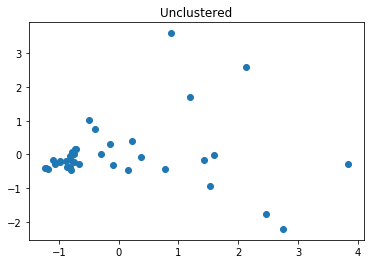

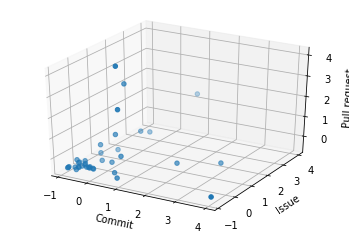

Clustering for 2014


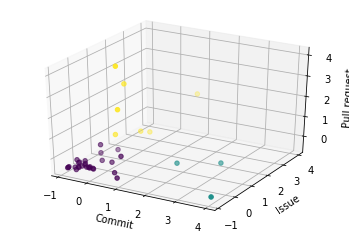

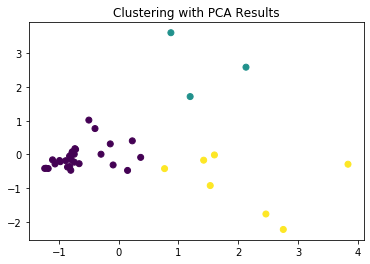

Centers of the Clusters:
Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow

     commit     issue  pull_request
0 -0.369190 -0.405166     -0.385947
1  2.940898  0.531054     -0.387083
2  0.216375  1.393068      1.709682


Clustering for 2015


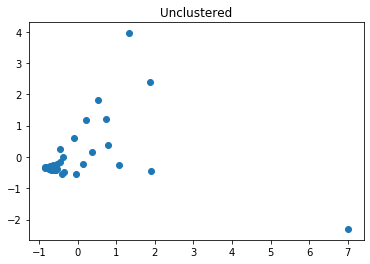

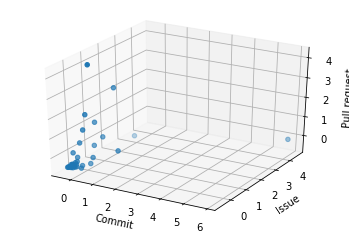

Clustering for 2015


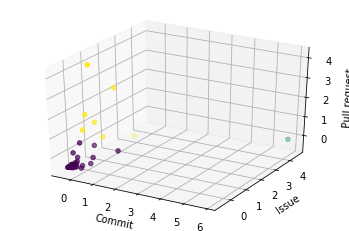

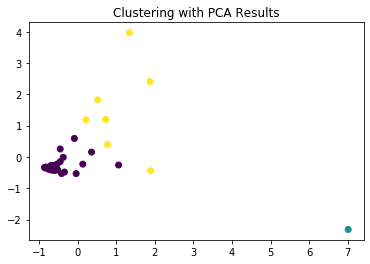

Centers of the Clusters:
Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow

     commit     issue  pull_request
0 -0.185871 -0.362759     -0.373480
1  5.859579  4.534586     -0.129045
2 -0.040491  0.906883      1.619065


Clustering for 2016


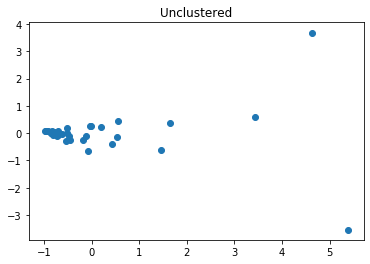

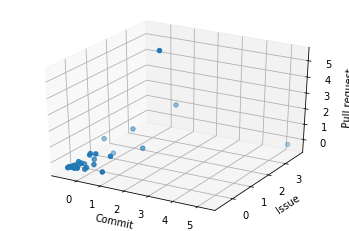

Clustering for 2016


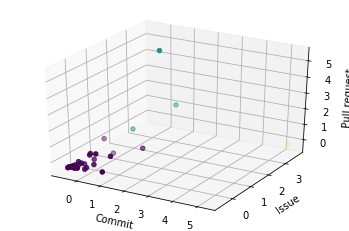

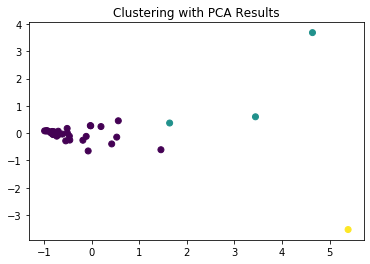

Centers of the Clusters:
Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow

     commit     issue  pull_request
0 -0.230885 -0.299322     -0.236531
1  0.863737  2.152246      2.754255
2  5.258885  3.720217     -0.220695


Clustering for 2017


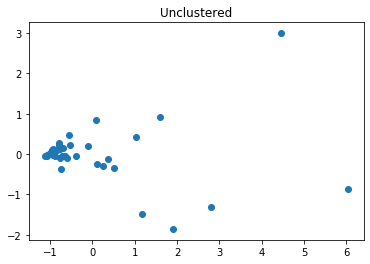

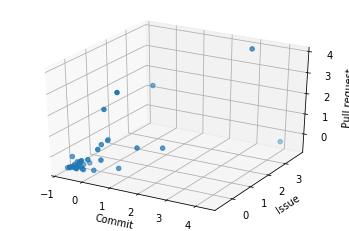

Clustering for 2017


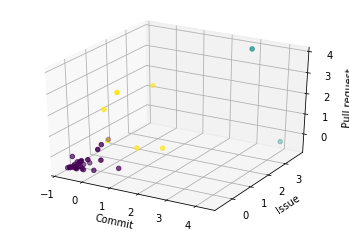

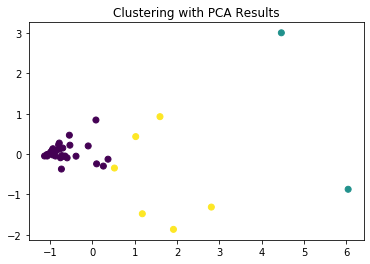

Centers of the Clusters:
Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow

     commit     issue  pull_request
0 -0.355067 -0.385231     -0.391608
1  3.594535  3.490844      1.903304
2  0.577159  0.762542      1.323605


Clustering for 2018


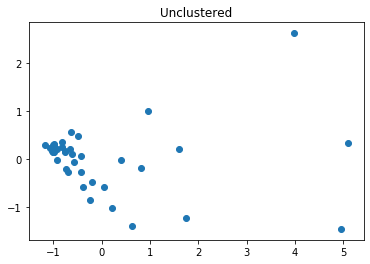

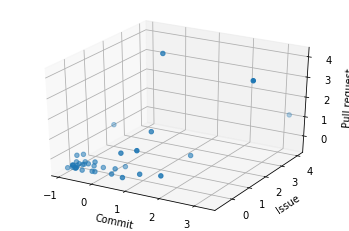

Clustering for 2018


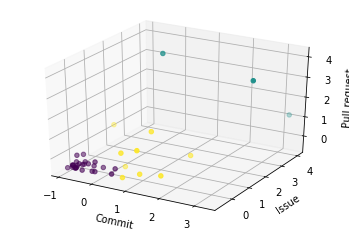

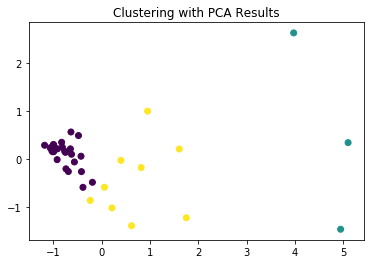

Centers of the Clusters:
Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow

     commit     issue  pull_request
0 -0.523046 -0.432667     -0.391567
1  2.152875  3.009775      2.893353
2  0.793397  0.246669      0.166742




In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

test = dict()

for year in selected_years:
    df_year = new_df.loc[new_df['year'] == year]
    df_year = df_year.drop(['year','project_id'], axis =1 )
    df_year = df_year.fillna(0)
    df_year = scaler.fit_transform(df_year)
    
    pca = PCA(n_components=2)
    pca.fit(df_year)
    pca_data = pca.transform(df_year)
    pca_df = pd.DataFrame(pca_data, columns = ['PC1', 'PC2'])
    print('Clustering for %s' % year)
    #print("Variance explained by the principle components:", pca.explained_variance_ratio_)
    #print("Ratio of variance explained: ", sum(pca.explained_variance_ratio_))
    
    plt.figure()
    plt.scatter(pca_df['PC1'], pca_df['PC2'])
    plt.title('Unclustered')
    plt.show()
    

    df_year_plot = pd.DataFrame(df_year, columns = ['commit_id', 'issue_id', 'pull_request_id'])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(df_year_plot['commit_id'], df_year_plot['issue_id'], df_year_plot['pull_request_id'])
    ax.set_xlabel('Commit')
    ax.set_ylabel('Issue')
    ax.set_zlabel('Pull request')
    plt.show()
    
    km = KMeans(n_clusters = 3)
    km.fit(df_year)
    y_predicted = km.predict(df_year)
    centers = km.cluster_centers_
    centers = pd.DataFrame(centers, columns=['commit', 'issue', 'pull_request'])
    
    print('Clustering for %s' % year)


    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(df_year_plot['commit_id'], df_year_plot['issue_id'], df_year_plot['pull_request_id'], c=np.array(y_predicted))
    ax.set_xlabel('Commit')
    ax.set_ylabel('Issue')
    ax.set_zlabel('Pull request')
    plt.show()
    
    plt.figure()
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = y_predicted)
    plt.title('Clustering with PCA Results')
    plt.show()
    
    print('Centers of the Clusters:')
    print('Cluster 0: purple     Cluster 1: blue     Cluster 2: yellow')
    print()
    print(centers)
    print()
    print()
    
    df_year_plot['cluster'] = y_predicted
    test[year] = df_year_plot

In [51]:
df_2018 = test['2018']
df_2018['project'] = projects
df_2018
#df_2018.groupby('cluster').mean()

,commit_id,issue_id,pull_request_id,cluster,project
0,-0.780980,-0.588575,-0.366522,0,ant-ivy
1,-0.150295,-0.512092,-0.523285,0,archiva
2,0.354253,2.372416,4.119323,1,calcite
3,0.893840,-0.107824,0.694646,2,cayenne
4,-0.710904,-0.512092,-0.511226,0,commons-bcel
5,-0.731927,-0.555797,-0.511226,0,commons-beanutils
6,-0.689881,-0.588575,-0.487109,0,commons-codec
7,-0.262417,-0.293569,-0.185641,0,commons-collections
8,1.048007,-0.260790,-0.366522,2,commons-compress
9,0.263154,-0.162455,-0.426815,0,commons-configuration
